In [1]:
import sys

sys.path.append('../GraphStructureLearning')

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import pickle

from torch_geometric.data import Data as gData
from torch_geometric.utils import to_networkx, to_undirected
from torch_geometric.nn import MessagePassing

import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric_temporal.nn.recurrent import DCRNN

In [3]:
from torch_geometric.utils import to_undirected, to_dense_adj, add_self_loops, sort_edge_index, remove_self_loops

# GTS

In [4]:
from models.GTS.gts_graph_learning import GTS_Graph_Learning
from models.GTS.gts_forecasting_module import GTS_Forecasting_Module
from models.GTS.DCRNN import DCRNN
from utils.utils import build_fully_connected_edge_idx, build_batch_edge_index

from glob import glob
import yaml
from easydict import EasyDict as edict

In [5]:
config_file = glob('./config/GTS/*.yaml')[0]
config = edict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))

In [6]:
config

{'exp_name': 1,
 'exp_dir': './exp',
 'use_gpu': False,
 'device': 'cpu',
 'seed': 1010,
 'model_name': 'GTS',
 'graph_learning_module': 'GTS',
 'graph_forecasting_module': 'GTS',
 'initial_edge_index': 'Fully Connected',
 'dataset': {'root': './data/spike_lambda_bin100',
  'name': 'spike_lambda_bin100',
  'total_time_length': 4800,
  'idx_ratio': 0.5,
  'window_size': 20,
  'slide': 5,
  'pred_step': 5,
  'train_valid_test': [4000, 4400, 4800],
  'save': './data/spike_lambda_bin100/'},
 'train': {'optimizer': 'Adam',
  'epoch': 2,
  'loss_function': 'MSELoss',
  'lr': 0.001,
  'momentum': 0.9,
  'wd': 0.0,
  'batch_size': 1,
  'lr_decay': 0.1,
  'lr_decay_steps': [10000]},
 'nodes_num': 100,
 'node_features': 1,
 'hidden_dim': 16,
 'embedding_dim': 16,
 'graph_learning': {'sequence': 3,
  'mode': 'adj',
  'to_symmetric': True,
  'kernel_size': [200, 80, 10],
  'stride': [20, 10, 5],
  'conv1_dim': 4,
  'conv2_dim': 4,
  'conv3_dim': 4},
 'forecasting_module': {'diffusion_k': 1,
  'num

In [7]:
# node_feas = torch.rand(config.nodes_num, config.node_features, 1000)
# edge_index = build_fully_connected_edge_idx(num_nodes=config.nodes_num)

In [8]:
spike = pickle.load(open('./data/spk_bin_n100.pickle', 'rb'))

spike = torch.FloatTensor(spike[:,:4800])

In [9]:
config.nodes_num = 100

In [10]:
edge_index = build_fully_connected_edge_idx(num_nodes=config.nodes_num)

In [16]:
def adj_sampling(adj, edge_index):
    z_1 = F.gumbel_softmax(adj, hard=True)
    z_adj = torch.where(z_1[:,0])

    b= edge_index[0,:][z_adj]
    c = edge_index[1,:][z_adj]

    a = torch.stack([b,c])
    return a

In [17]:
gl = GTS_Graph_Learning(config)

In [20]:
epoch = 10

torch.Size([2, 3037])
torch.Size([2, 1692])
torch.Size([2, 929])
torch.Size([2, 481])
torch.Size([2, 262])
torch.Size([2, 138])
torch.Size([2, 76])
torch.Size([2, 44])
torch.Size([2, 29])
torch.Size([2, 18])


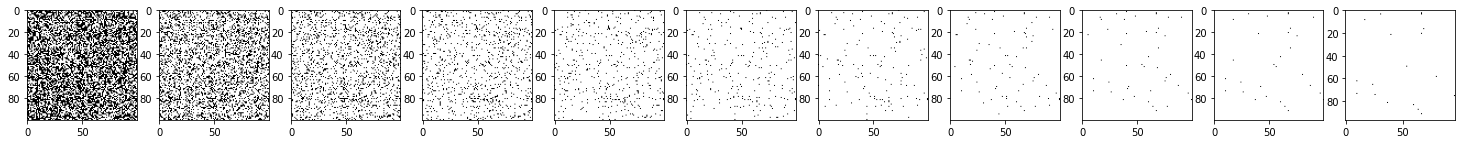

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=epoch+1, figsize=(25.6, 18.0))

adj = gl(spike, edge_index)
_edge_index = adj_sampling(adj, edge_index)
temp = to_dense_adj(_edge_index)[0]
axes[0].imshow(temp, cmap='Greys')

for ii in range(epoch):
    adj = gl(spike, _edge_index)
    _edge_index = adj_sampling(adj, _edge_index)
    
    temp = to_dense_adj(_edge_index)[0]
    axes[ii+1].imshow(temp, cmap='Greys')
    print(_edge_index.shape)